In [260]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk import PorterStemmer
from nltk import LancasterStemmer
import joblib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib.colors import ListedColormap
from sklearn.metrics import ConfusionMatrixDisplay

In [261]:
def clean_data(data):
    data = data.fillna('')
    if 'id' in data.columns:
        data.drop(columns=['id'], inplace=True)
    return data

def select_features(data,colx,coly=None):
    X = data[colx].apply(lambda x: ' '.join(x), axis=1)
    if coly is None:
        return X
    else:
        y = data[coly]
    return X,y

def preprocess_data(data):
    data = data.str.replace('[^a-zA-Z0-9]', ' ',regex=True)
    if not stopwords.words('english'):
        nltk.download('stopwords')
    else:
        st_eng = set(stopwords.words('english'))   
    if not os.path.exists('./models/lancasterstemmer.joblib'):
            lancasterstemmer = LancasterStemmer()
            joblib.dump(lancasterstemmer, './models/lancasterstemmer.joblib', compress=0, protocol=None, cache_size=None)
            data = data.apply(lambda words: ' '.join(lancasterstemmer.stem(word.lower()) for word in words.split() if word not in st_eng))
    else:
        lancasterstemmer = joblib.load('./models/lancasterstemmer.joblib')
        data = data.apply(lambda words: ' '.join(lancasterstemmer.stem(word.lower()) for word in words.split() if word not in st_eng))
    return data



def train_split(x_data,y_data,test_size,rand):
    return train_test_split(x_data,y_data,test_size=test_size,random_state= rand)


def vectorize_data(data,stage):
    if stage == 'train' and not os.path.exists('./models/TfidfVectorizer.joblib'):  
        vectorizer = TfidfVectorizer()
        vectorizer.fit(data)
        joblib.dump(vectorizer, './models/TfidfVectorizer.joblib', compress=0, protocol=None, cache_size=None)
        data = vectorizer.transform(data)
    else:
        vectorizer = joblib.load('./models/TfidfVectorizer.joblib')
        data = vectorizer.transform(data)
    return data
    
def get_prediction(model,data):
    y_pred = model.predict(data)
    return y_pred

def get_report(actual,predicted):
    matrix = confusion_matrix(actual, predicted)
    report = classification_report(actual, predicted)
    return matrix,report

In [262]:
data = pd.read_csv('./data/train.csv')

In [263]:
data.isna().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [264]:


data = clean_data(data)
X,y =select_features(data,['title','author','text'],['label'])
X = preprocess_data(X)
X_train,X_test,y_train,y_test = train_split(X,y,0.2,0)
X_train = vectorize_data(X_train,'train')
X_test = vectorize_data(X_test,'test')

# Logistic Regression

d:\ProgramData\Miniconda3\envs\fake-news\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pridiction Values is [0 1 1 ... 0 1 1]
[[1962   84]
 [  92 2022]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2046
           1       0.96      0.96      0.96      2114

    accuracy                           0.96      4160
   macro avg       0.96      0.96      0.96      4160
weighted avg       0.96      0.96      0.96      4160



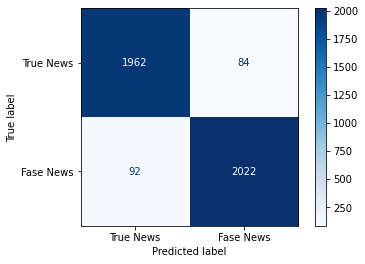

In [265]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
linear = LR.fit(X_train, y_train)
y_pred = get_prediction(linear,X_test)
matrix,report = get_report(y_test,y_pred)

print("Pridiction Values is",y_pred)
print(matrix)
cm = ConfusionMatrixDisplay(matrix, display_labels=["True News", "Fase News"]).plot(cmap='Blues')
print(cm)
print(report)


Text(0, 0.5, 'Accuracy')

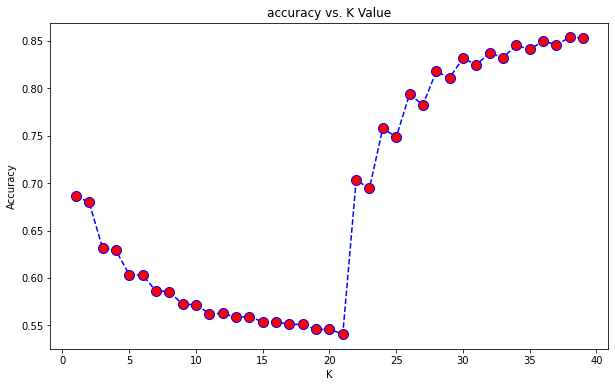

In [266]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
acc = []

for i in range(1,40):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train.values.ravel())
    yhat = neigh.predict(X_test)
    acc.append(metrics.accuracy_score(y_test, yhat))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,40),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')

Pridiction Values is [0 1 1 ... 0 1 0]
[[1638  408]
 [ 180 1934]]
              precision    recall  f1-score   support

           0       0.90      0.80      0.85      2046
           1       0.83      0.91      0.87      2114

    accuracy                           0.86      4160
   macro avg       0.86      0.86      0.86      4160
weighted avg       0.86      0.86      0.86      4160



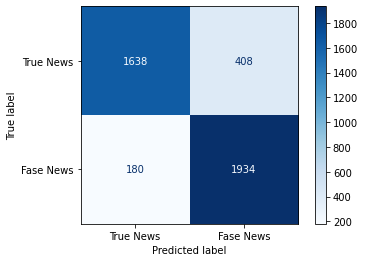

In [267]:
k = 40

knn_optimal = KNeighborsClassifier(n_neighbors = k, metric = 'euclidean')
knn_optimal.fit(X_train, y_train.values.ravel())
y_pred = get_prediction(knn_optimal,X_test)
matrix,report = get_report(y_test,y_pred)
print("Pridiction Values is",y_pred)
print(matrix)
cm = ConfusionMatrixDisplay(matrix, display_labels=["True News", "Fase News"]).plot(cmap='Blues')
print(cm)
print(report)


# DecisionTreeClassifier

Text(0, 0.5, 'Accuracy')

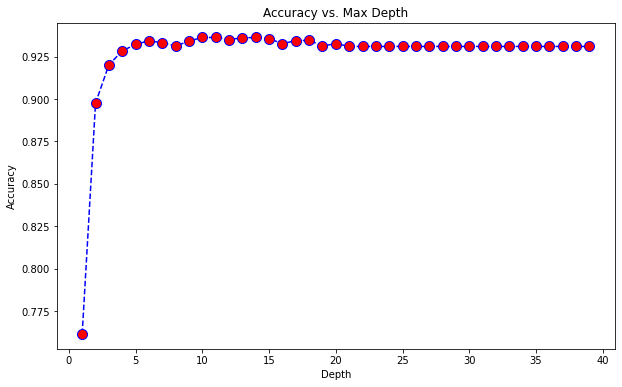

In [268]:
from sklearn.tree import DecisionTreeClassifier
acc = []
for i in range(1,40):
    dt = DecisionTreeClassifier(criterion = 'entropy', random_state = 0, max_depth = i)
    dt.fit(X_train, y_train.values.ravel())
    Pred_DT = dt.predict(X_test)
    acc.append(metrics.accuracy_score(y_test, Pred_DT))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,40),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Accuracy vs. Max Depth')
plt.xlabel('Depth')
plt.ylabel('Accuracy')

Pridiction Values is [0 1 1 ... 0 1 1]
[[1910  136]
 [ 134 1980]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      2046
           1       0.94      0.94      0.94      2114

    accuracy                           0.94      4160
   macro avg       0.94      0.94      0.94      4160
weighted avg       0.94      0.94      0.94      4160



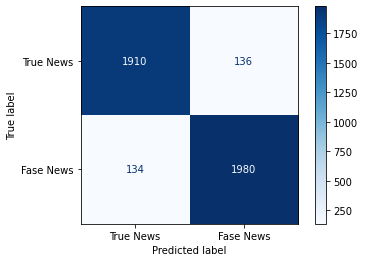

In [269]:
depth = 12
dt = DecisionTreeClassifier(criterion = 'entropy', random_state = 0, max_depth = depth)
dt.fit(X_train, y_train)
y_pred = get_prediction(dt,X_test)
matrix,report = get_report(y_test,y_pred)
print("Pridiction Values is",y_pred)
print(matrix)
cm = ConfusionMatrixDisplay(matrix, display_labels=["True News", "Fase News"]).plot(cmap='Blues')
print(cm)
print(report)

Text(0, 0.5, 'Accuracy')

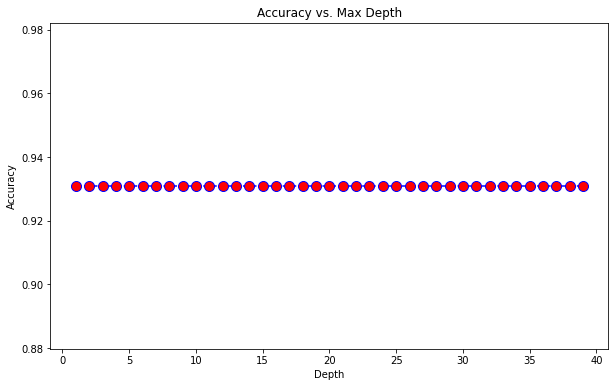

In [270]:
from sklearn.ensemble import RandomForestClassifier
acc = []
for i in range(1,40):
    rf = RandomForestClassifier(n_estimators = i, criterion = 'entropy',random_state=0)
    rf.fit(X_train, y_train.values.ravel())
    Pred_RF = rf.predict(X_test)
    acc.append(metrics.accuracy_score(y_test, Pred_DT))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,40),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Accuracy vs. Max Depth')
plt.xlabel('Depth')
plt.ylabel('Accuracy')

Pridiction Values is [0 1 1 ... 0 1 1]
[[1968   78]
 [ 185 1929]]
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      2046
           1       0.96      0.91      0.94      2114

    accuracy                           0.94      4160
   macro avg       0.94      0.94      0.94      4160
weighted avg       0.94      0.94      0.94      4160



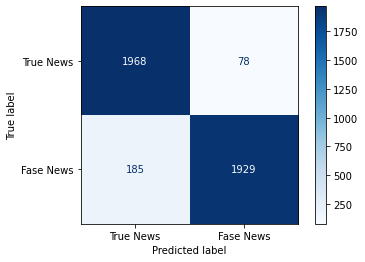

In [271]:

rf = RandomForestClassifier(n_estimators = 100, criterion = 'entropy',random_state=0)
rf.fit(X_train, y_train.values.ravel())
y_pred = get_prediction(rf,X_test)
matrix,report = get_report(y_test,y_pred)
print("Pridiction Values is",y_pred)
print(matrix)
cm = ConfusionMatrixDisplay(matrix, display_labels=["True News", "Fase News"]).plot(cmap='Blues')
print(cm)
print(report)


In [272]:
# from sklearn.model_selection import GridSearchCV
# forest_params = {"max_depth": [1, 40],
#               "max_features": [1, 3, 10],
#               "min_samples_split": [1, 3, 10],
#               "min_samples_leaf": [1, 3, 10],
#               # "bootstrap": [True, False],
#               "criterion": ["gini", "entropy"]}
# rf_grid = RandomForestClassifier()
# grid_search =GridSearchCV(rf_grid, forest_params, cv = 5, scoring='accuracy')
# grid_search.fit(X_train, y_train.values.ravel())
# y_pred = get_prediction(grid_search,X_test)
# matrix,report = get_report(y_test,y_pred)
# print("Pridiction Values is",y_pred)
# print(matrix)
# print(report)
# print(grid_search.best_params_)
# print(grid_search.best_score_)

d:\ProgramData\Miniconda3\envs\fake-news\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pridiction Values is [0 1 1 ... 0 1 1]
[[1979   67]
 [  52 2062]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2046
           1       0.97      0.98      0.97      2114

    accuracy                           0.97      4160
   macro avg       0.97      0.97      0.97      4160
weighted avg       0.97      0.97      0.97      4160



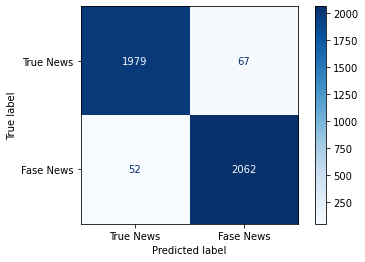

In [273]:
from sklearn.svm import SVC
svm = SVC(kernel = 'linear', random_state = 0, probability = True)
svm.fit(X_train, y_train)
y_pred = get_prediction(svm,X_test)
matrix,report = get_report(y_test,y_pred)
print("Pridiction Values is",y_pred)
print(matrix)
cm = ConfusionMatrixDisplay(matrix, display_labels=["True News", "Fase News"]).plot(cmap='Blues')
print(cm)
print(report)

# Bagging Ensemble Classifier

In [274]:
# from sklearn.ensemble import BaggingClassifier
# from sklearn.datasets import make_classification
# X, y = make_classification(n_samples=100, n_features=50000,n_informative=2, n_redundant=0,random_state=0, shuffle=False)
# #print(X[1].reshape(-1, 1))
# clf = BaggingClassifier(base_estimator=SVC(), n_estimators=10, random_state=0).fit(X, y)
# y_pred = clf.predict(X[:50000])
# clf.score(X, y)
# print(clf.score(X, y))

In [ ]:
from xgboost import XGBClassifier
xg = XGBClassifier()
xg.fit(X_train,y_train)
y_pred = get_prediction(xg,X_test)
matrix,report = get_report(y_test,y_pred)
print("Pridiction Values is",y_pred)
print(matrix)
cm = ConfusionMatrixDisplay(matrix, display_labels=["True News", "Fase News"]).plot(cmap='Blues')
print(cm)
print(report)

Pridiction Values is [0 1 1 ... 0 1 1]
[[1984   62]
 [  46 2068]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      2046
           1       0.97      0.98      0.97      2114

    accuracy                           0.97      4160
   macro avg       0.97      0.97      0.97      4160
weighted avg       0.97      0.97      0.97      4160



In [ ]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier(iterations=200)
cat.fit(X_train,y_train)
y_pred = get_prediction(cat,X_test)
matrix,report = get_report(y_test,y_pred)
print("Pridiction Values is",y_pred)
print(matrix)
cm = ConfusionMatrixDisplay(matrix, display_labels=["True News", "Fase News"]).plot(cmap='Blues')
print(cm)
print(report)


Learning rate set to 0.149735
0:	learn: 0.5208237	total: 5.37s	remaining: 17m 49s
1:	learn: 0.4146744	total: 7.23s	remaining: 11m 55s
2:	learn: 0.3560062	total: 8.91s	remaining: 9m 45s
3:	learn: 0.2989470	total: 10.2s	remaining: 8m 18s
4:	learn: 0.2513948	total: 11.4s	remaining: 7m 23s
5:	learn: 0.2285160	total: 12.7s	remaining: 6m 49s
6:	learn: 0.2131620	total: 13.8s	remaining: 6m 20s
7:	learn: 0.1996908	total: 14.9s	remaining: 5m 57s
8:	learn: 0.1907128	total: 16s	remaining: 5m 39s
9:	learn: 0.1822152	total: 17.1s	remaining: 5m 25s
10:	learn: 0.1749928	total: 18.2s	remaining: 5m 13s
11:	learn: 0.1681223	total: 19.3s	remaining: 5m 2s
12:	learn: 0.1643066	total: 20.3s	remaining: 4m 52s
13:	learn: 0.1593798	total: 21.4s	remaining: 4m 44s
14:	learn: 0.1546871	total: 22.6s	remaining: 4m 38s
15:	learn: 0.1509029	total: 23.6s	remaining: 4m 31s
16:	learn: 0.1462108	total: 24.8s	remaining: 4m 27s
17:	learn: 0.1430075	total: 26s	remaining: 4m 22s
18:	learn: 0.1405670	total: 27s	remaining: 4m 1

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=50, learning_rate=1)
ada.fit(X_train, y_train)
y_pred = get_prediction(ada,X_test)
matrix,report = get_report(y_test,y_pred)
print("Pridiction Values is",y_pred)
print(matrix)
cm = ConfusionMatrixDisplay(matrix, display_labels=["True News", "Fase News"]).plot(cmap='Blues')
print(cm)
print(report)

d:\ProgramData\Miniconda3\envs\fake-news\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pridiction Values is [0 1 1 ... 0 1 1]
[[1957   89]
 [  79 2035]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2046
           1       0.96      0.96      0.96      2114

    accuracy                           0.96      4160
   macro avg       0.96      0.96      0.96      4160
weighted avg       0.96      0.96      0.96      4160



In [ ]:
# from tensorflow.keras.layers import Embedding,Dropout
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.preprocessing.text import one_hot
# from tensorflow.keras.layers import LSTM,Bidirectional,GRU
# from tensorflow.keras.layers import Dense

# train_x = np.asarray(X_train)
# train_y = np.asarray(y_train)
# validation_x = np.asarray(X_test)
# validation_y = np.asarray(y_test)


# embedding_feature_vector = 60
# model = Sequential()
# model.add(Embedding(2000,embedding_feature_vector,input_length=1000))
# model.add(Dropout(0.3))
# model.add(LSTM(100))
# model.add(Dropout(0.3))
# model.add(Dense(1,activation='sigmoid'))
# model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# model.fit(X_train.reshape(1, -1),y_train.reshape(1, -1),validation_data=(X_test.reshape(1, -1),y_test.reshape(1, -1)),epochs=10)
# y_pred = get_prediction(model,X_test)
# matrix,report = get_report(y_test,y_pred)
# print("Pridiction Values is",y_pred)
# print(matrix)
# print(report)




AttributeError: 'DataFrame' object has no attribute 'reshape'

In [ ]:
error_rate = []
 
for i in range(1, 40):
     
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))
 
plt.figure(figsize =(10, 6))
plt.plot(range(1, 40), error_rate, color ='blue',
                linestyle ='dashed', marker ='o',
         markerfacecolor ='red', markersize = 10)
 
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

d:\ProgramData\Miniconda3\envs\fake-news\lib\site-packages\sklearn\neighbors\_classification.py:200: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\jatin\AppData\Local\Temp\ipykernel_3764\3678204328.py:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  error_rate.append(np.mean(pred_i != y_test))


ValueError: Unable to coerce to Series, length must be 1: given 4160

In [ ]:
from sklearn.ensemble import RandomForestRegressor
 
rf = RandomForestRegressor(n_estimators = 100, random_state = 0)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print("Random Forest model accuracy(in %):", 
metrics.accuracy_score(y_test, rf_pred)*100)

In [ ]:
X_grid = np.arrange(min(X_train), max(X_train), 0.01)
 
# reshape for reshaping the data into a len(X_grid)*1 array,
# i.e. to make a column out of the X_grid value                 
X_grid = X_grid.reshape((len(X_grid), 1))
 
# Scatter plot for original data
plt.scatter(X_train, y_train, color = 'blue') 
 
# plot predicted data
plt.plot(X_grid, rf.predict(X_grid),
         color = 'green')
plt.title('Random Forest Regression')
plt.xlabel('Position level')
plt.ylabel('Salary')
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor


In [ ]:
def model(model,X_train, y_train, y_test):
    mod = model.fit(X_train, y_train)
    y_pred = mod.predict(X_test)
    #print("model accuracy(in %):", metrics.accuracy_score(y_test, y_pred)*100)
    print(classification_report(y_test, y_pred))

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 10)
model(knn, X_train, y_train, y_test)

              precision    recall  f1-score   support

           0       0.99      0.06      0.12      8299
           1       0.52      1.00      0.68      8341

    accuracy                           0.53     16640
   macro avg       0.75      0.53      0.40     16640
weighted avg       0.75      0.53      0.40     16640



In [ ]:
from sklearn.neighbors import KNeighborsClassifier
 
knn = KNeighborsClassifier(n_neighbors = 2)
model(knn)
print(classification_report(y_test, knn_pred))

 K-nearest  neighbor (KNN),  support  vector machine  (SVM),  logistic  regression  (LR),  linear  support  vector machine (LSVM), decision tree (DT), 